In [24]:
# importing the required modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

### Signal without decay

In [38]:
# info about the data
f = 3.3 # initial frequency
freq_sampling =  114795 / 5.78562
noise_add = True
triggering = True
N_sample = 120000 # number of samples
Total_time = N_sample / freq_sampling # total time
amplitudes = [0.5, 0.7, 1.0, 1.2, 1.5] # amplitudes of the signal
phases = [0, np.pi/8, 2 * np.pi/8, 3 * np.pi/8, 4 * np.pi/8, 5 * np.pi/8, 6 * np.pi/8, 7 * np.pi/8] # phases of the signal

# random amplitude
amplitude = amplitudes[np.random.randint(0, len(amplitudes))]
phase = phases[np.random.randint(0, len(phases))]

t = np.linspace(0, Total_time, N_sample, endpoint=False) # time array

# creating a sin wave with the frequency array
y = amplitude * np.sin(2 * np.pi * f * t) + 0.0275

# adding some noise to the signal
if noise_add:
    y = y + 0.001 * np.random.normal(size=t.size)

# creeating a squarae wave with the frequency array and a phase shift of 90 degrees
y_square = 0.05*np.sin(2 * np.pi * f * t + phase)

# converting the signal to a square wave
y_square = 0.025 * np.sign(y_square) + 0.025

# adding some noise to the signal
if noise_add:
    y_square = y_square + 0.0009 * np.random.normal(size=t.size)


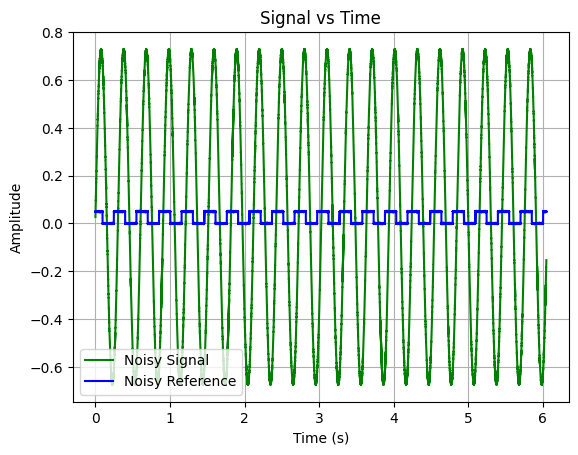

In [37]:
# plotting the current signal and the reference signal
plt.plot(t, y, 'g',label='Noisy Signal')
# plt.plot(t, y, 'r',label='Original Signal')
plt.plot(t, y_square, 'b',label='Noisy Reference')
# plt.plot(t, y_square, 'y',label='Original Reference')
plt.title('Signal vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

In [30]:
# finding the first rise index and further indices where reference signal gradiant changes
ref_data = np.array([t, y_square])
sig_data = np.array([t, y])

ref_sig_max = np.max(ref_data[1])
ref_sig_min = np.min(ref_data[1])

# centralizing the reference signal
ref_data[1] = ref_data[1] - ((ref_sig_max + ref_sig_min)/2)

first_rise_idx = 0
for i in range(1, N_sample):
    if ref_data[1][i] > 0 and ref_data[1][i-1] < 0:
        first_rise_idx = i
        break

ref_cross_idx = [first_rise_idx]
for i in range(first_rise_idx + 1, N_sample):
    if ref_data[1][i]*ref_data[1][i-1] < 0:
        ref_cross_idx.append(i)

triggered_sig = sig_data[1][first_rise_idx:]
triggered_ref = ref_data[1][first_rise_idx:]
triggered_time = sig_data[0][first_rise_idx:] - sig_data[0][first_rise_idx] # time starts from zero

ref_cross_idx = np.array(ref_cross_idx)
ref_cross_idx = ref_cross_idx - first_rise_idx # resetting the indices to start from zero

print(triggered_sig.shape)
print(triggered_ref.shape)
print(triggered_time.shape)
print(triggered_time)
print()
print(ref_cross_idx.shape)
print(ref_cross_idx)


(115490,)
(115490,)
(115490,)
[0.00000000e+00 5.03995819e-05 1.00799164e-04 ... 5.82049651e+00
 5.82054691e+00 5.82059731e+00]

(39,)
[     0   3006   6012   9019  12025  15031  18038  21044  24050  27056
  30063  33069  36075  39082  42088  45094  48100  51107  54113  57119
  60125  63132  66138  69144  72151  75157  78163  81169  84176  87182
  90188  93195  96201  99207 102213 105220 108226 111232 114238]


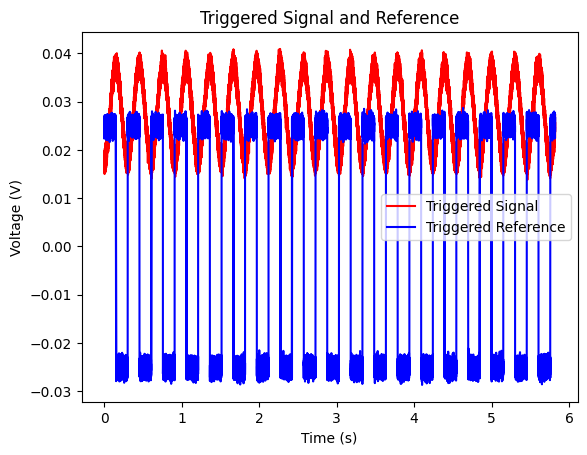

In [31]:
# plotting the triggered signals
plt.plot(triggered_time, triggered_sig, 'r', label='Triggered Signal')
plt.plot(triggered_time, triggered_ref, 'b', label='Triggered Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Triggered Signal and Reference')
plt.legend()
plt.show()

#### Square wave to sine wave.

In [32]:
# finding the frequency of the triggered square wave using the fft
# yf = fft(triggered_ref)
# xf = fftfreq(len(triggered_ref), 1 / freq_sampling)
# freq = xf[np.argmax(np.abs(yf))]
# print('Frequency of the triggered square wave:', freq, 'Hz')

# fft on the original reference signal
yf = fft(y_square)[1:]
xf = fftfreq(N_sample, 1 / freq_sampling)[1:]
freq = xf[np.argmax(np.abs(yf))]
print('Frequency of the original square wave:', freq, 'Hz')


Frequency of the original square wave: 3.3069057421676504 Hz


sus!


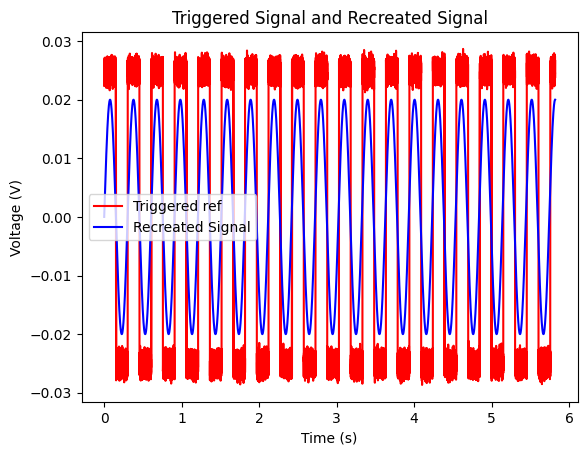

In [33]:
# recreating the sine wave with the same frequency as the triggered square wave
y = 0.02*np.sin(2 * np.pi * freq * triggered_time)

# plotting the triggered signal and the recreated sine wave
plt.plot(triggered_time, triggered_ref, 'r', label='Triggered ref')
plt.plot(triggered_time, y, 'b', label='Recreated Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Triggered Signal and Recreated Signal')
plt.legend()
plt.show()


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

### Signal implementation

In [40]:
# info about the data
f = 3.3 # initial frequency
freq_sampling =  114795 / 5.78562
noise_add = True
triggering = True
N_sample = 120000 # number of samples
Total_time = N_sample / freq_sampling # total time
amplitudes = [0.5, 0.7, 1.0, 1.2, 1.5] # amplitudes of the signal
phases = [0, np.pi/8, 2 * np.pi/8, 3 * np.pi/8, 4 * np.pi/8, 5 * np.pi/8, 6 * np.pi/8, 7 * np.pi/8] # phases of the signal

# random amplitude
amplitude = amplitudes[np.random.randint(0, len(amplitudes))]
phase = phases[np.random.randint(0, len(phases))]

t = np.linspace(0, Total_time, N_sample, endpoint=False) # time array

# creating a sin wave with the frequency array
y = amplitude * np.sin(2 * np.pi * f * t) + 0.0275

# adding some noise to the signal
if noise_add:
    y = y + 0.001 * np.random.normal(size=t.size)

# creeating a squarae wave with the frequency array and a phase shift of 90 degrees
y_square = 0.05*np.sin(2 * np.pi * f * t + phase)

# converting the signal to a square wave
y_square = 0.025 * np.sign(y_square) + 0.025

# adding some noise to the signal
if noise_add:
    y_square = y_square + 0.0009 * np.random.normal(size=t.size)


### lockin implementation

We have:
- freq: reference frequency
- triggered ref

In [41]:
# centralizing the reference signal
ref_data[1] = ref_data[1] - ((ref_sig_max + ref_sig_min)/2)

first_rise_idx = 0
for i in range(1, N_sample):
    if ref_data[1][i] > 0 and ref_data[1][i-1] < 0:
        first_rise_idx = i
        break

triggered_sig = sig_data[1][first_rise_idx:]
triggered_ref = ref_data[1][first_rise_idx:]
triggered_time = sig_data[0][first_rise_idx:] - sig_data[0][first_rise_idx] # time starts from zero

# fft on the original reference signal
yf = fft(y_square)[1:]
xf = fftfreq(N_sample, 1 / freq_sampling)[1:]
freq = xf[np.argmax(np.abs(yf))]
print('Frequency of the original square wave:', freq, 'Hz')

# creating sin and cos reference signals
ref_sin = 2 * np.sin(2 * np.pi * freq * triggered_time)
ref_cos = 2 * np.cos(2 * np.pi * freq * triggered_time)

# multiplying the triggered signal with the sin and cos reference signals
y_sin = triggered_sig * ref_sin
y_cos = triggered_sig * ref_cos

# taking the fft of the multiplied signals and finding the dc components
yf_sin = fft(y_sin)
yf_cos = fft(y_cos)

# finding the dc components
dc_sin = yf_sin[0].real / (len(ref_sin))
dc_cos = yf_cos[0].real / (len(ref_cos))

# finding voltage amplitude and phase
A = np.sqrt(dc_sin**2 + dc_cos**2)
phi = np.arctan(dc_cos/dc_sin)
phi = np.degrees(phi)

print('Amplitude:', A)
print('Phase:', phi)
print('Frequency:', freq)

print('\nOriginal Amplitude:', amplitude)
print('Original Phase:', phase)
print('Original Frequency:', f)

Frequency of the original square wave: 3.3069057421676504 Hz
Amplitude: 0.009973424077176487
Phase: -7.429465064092288
Frequency: 3.3069057421676504

Original Amplitude: 0.5
Original Phase: 0.7853981633974483
Original Frequency: 3.3
